In [1]:
# =====================================================
# BLOCK 1 — Environment & Imports
# =====================================================

!pip install -q protobuf==3.20.3

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import shutil
import random
from pathlib import Path

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.1 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptograp

2026-01-10 21:12:46.436218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768079566.631543      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768079566.686862      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# =====================================================
# BLOCK 2 — Dataset Configuration
# =====================================================

SOURCE_DIR = Path("/kaggle/input/plants-dataset/Plants-Dataset")
DEST_DIR   = Path("/kaggle/working/plants_split")

TRAIN_RATIO = 0.7
VAL_RATIO   = 0.2
TEST_RATIO  = 0.1

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6


In [3]:
# =====================================================
# BLOCK 3 — Clean Destination Directory
# =====================================================

if DEST_DIR.exists():
    shutil.rmtree(DEST_DIR)

for split in ["train", "val", "test"]:
    (DEST_DIR / split).mkdir(parents=True, exist_ok=True)


In [4]:
# =====================================================
# BLOCK 4 — Dataset Splitting
# =====================================================

for class_dir in SOURCE_DIR.iterdir():
    if not class_dir.is_dir():
        continue

    images = [
        img for img in class_dir.glob("*")
        if img.suffix.lower() in [".jpg", ".png", ".jpeg"]
    ]

    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * TRAIN_RATIO)
    n_val   = int(n_total * VAL_RATIO)

    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    for split_name, split_imgs in splits.items():
        split_class_dir = DEST_DIR / split_name / class_dir.name
        split_class_dir.mkdir(parents=True, exist_ok=True)

        for img_path in split_imgs:
            shutil.copy2(img_path, split_class_dir / img_path.name)

    print(
        f"{class_dir.name}: "
        f"Train={len(splits['train'])}, "
        f"Val={len(splits['val'])}, "
        f"Test={len(splits['test'])}"
    )


Strawberry___Leaf_scorch: Train=776, Val=221, Test=112
Peach___healthy: Train=251, Val=72, Test=37
Apple___Apple_scab: Train=441, Val=126, Test=63
Apple___Black_rot: Train=434, Val=124, Test=63
Peach___Bacterial_spot: Train=1607, Val=459, Test=231
Apple___Cedar_apple_rust: Train=192, Val=55, Test=28
Strawberry___healthy: Train=319, Val=91, Test=46
Apple___healthy: Train=1151, Val=329, Test=165


In [5]:
# =====================================================
# BLOCK 5 — Data Generators
# =====================================================

TRAIN_DIR = str(DEST_DIR / "train")
VAL_DIR   = str(DEST_DIR / "val")
TEST_DIR  = str(DEST_DIR / "test")

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [6]:
# =====================================================
# BLOCK 6 — Dataset Loaders
# =====================================================

train_set = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_set = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_set = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_set.class_indices.keys())


Found 5171 images belonging to 8 classes.
Found 1477 images belonging to 8 classes.
Found 745 images belonging to 8 classes.


In [7]:
# =====================================================
# BLOCK 7 — Model Definition (Feature Extraction)
# =====================================================

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_set.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


I0000 00:00:1768079607.668864      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
# =====================================================
# BLOCK 8 — Compile & Train (Phase 1)
# =====================================================

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint(
        "/kaggle/working/vgg16_best.weights.h5",
        save_best_only=True,
        save_weights_only=True
    )
]

history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1768079615.172194     131 service.cc:148] XLA service 0x7ed53400dd10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768079615.173039     131 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768079615.556624     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/162 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.2344 - loss: 15.0450 

I0000 00:00:1768079623.993872     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 ━━━━━━━━━━━━━━━━━━━━ 75s 395ms/step - accuracy: 0.5759 - loss: 4.5568 - val_accuracy: 0.9039 - val_loss: 0.2953
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 352ms/step - accuracy: 0.8189 - loss: 0.6526 - val_accuracy: 0.9465 - val_loss: 0.1620
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 346ms/step - accuracy: 0.8684 - loss: 0.4049 - val_accuracy: 0.9634 - val_loss: 0.1179
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 55s 341ms/step - accuracy: 0.8979 - loss: 0.3259 - val_accuracy: 0.9709 - val_loss: 0.0930
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 352ms/step - accuracy: 0.9198 - loss: 0.2486 - val_accuracy: 0.9736 - val_loss: 0.0923
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 58s 357ms/step - accuracy: 0.9317 - loss: 0.2390 - val_accuracy: 0.9736 - val_loss: 0.0984
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 353ms/step - accuracy: 0.9351 - loss: 0.2213 - val_accuracy: 0.9790 - val_loss: 0.0796
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.9427 - loss: 0.2000 - val

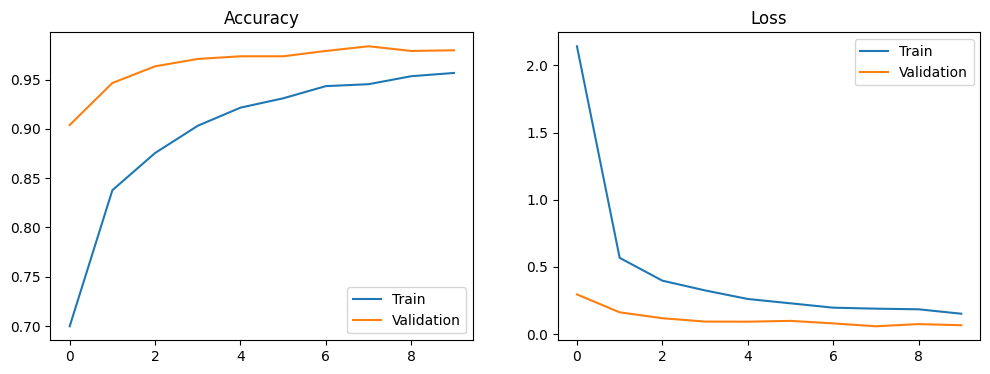

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9698 - loss: 0.0803
Test accuracy: 0.9852349162101746


In [9]:
# =====================================================
# BLOCK 9 — Evaluation & Metrics (Phase 1)
# =====================================================

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()

test_set.reset()
test_loss, test_acc = model.evaluate(test_set)
print("Test accuracy:", test_acc)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step


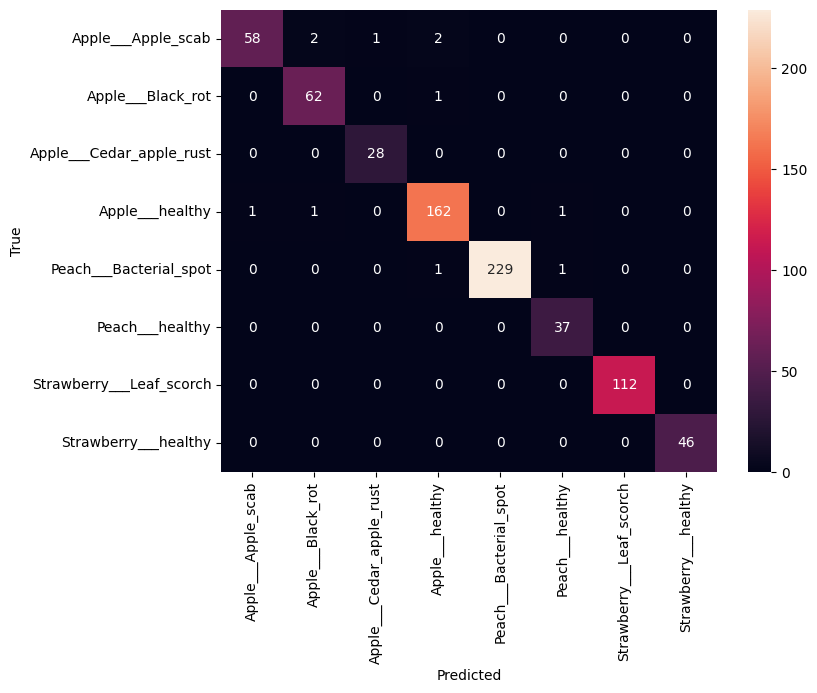

                          precision    recall  f1-score   support

      Apple___Apple_scab     0.9831    0.9206    0.9508        63
       Apple___Black_rot     0.9538    0.9841    0.9688        63
Apple___Cedar_apple_rust     0.9655    1.0000    0.9825        28
         Apple___healthy     0.9759    0.9818    0.9789       165
  Peach___Bacterial_spot     1.0000    0.9913    0.9957       231
         Peach___healthy     0.9487    1.0000    0.9737        37
Strawberry___Leaf_scorch     1.0000    1.0000    1.0000       112
    Strawberry___healthy     1.0000    1.0000    1.0000        46

                accuracy                         0.9852       745
               macro avg     0.9784    0.9847    0.9813       745
            weighted avg     0.9855    0.9852    0.9852       745



In [10]:
# =====================================================
# BLOCK 10 — Confusion Matrix & Classification Report
# =====================================================

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_set.reset()
y_true = test_set.classes
y_pred = np.argmax(model.predict(test_set), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)

print(report)

with open("/kaggle/working/classification_report.txt", "w") as f:
    f.write(report)


In [11]:
# =====================================================
# BLOCK 11 — Fine-Tuning (Block 5 Only)
# =====================================================

for layer in base_model.layers:
    layer.trainable = "block5" in layer.name

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=2,
    callbacks=callbacks
)

model.save_weights("/kaggle/working/vgg16_finetuned.weights.h5")


Epoch 1/2
162/162 ━━━━━━━━━━━━━━━━━━━━ 65s 369ms/step - accuracy: 0.9537 - loss: 0.1696 - val_accuracy: 0.9858 - val_loss: 0.0495
Epoch 2/2
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 348ms/step - accuracy: 0.9779 - loss: 0.0882 - val_accuracy: 0.9858 - val_loss: 0.0519


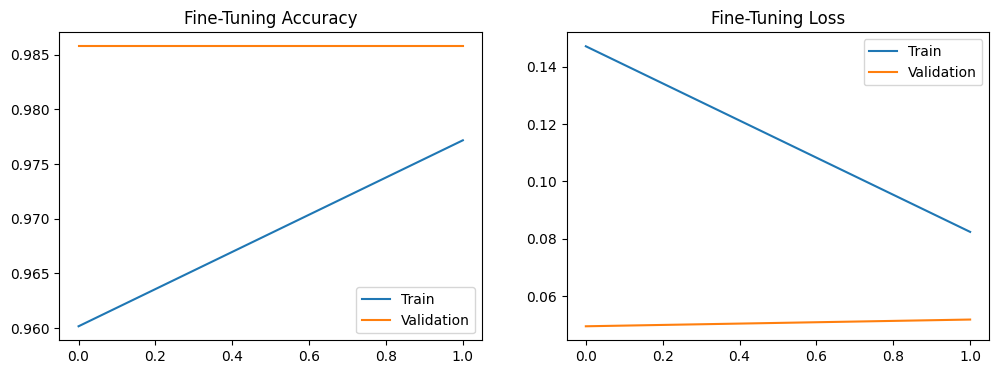

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9719 - loss: 0.0903
Final Test accuracy: 0.9865771532058716
Final Test loss: 0.039058804512023926


In [12]:
# =====================================================
# BLOCK 12 — Fine-Tuning Metrics & Final Evaluation
# =====================================================

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(fine_tune_history.history["accuracy"], label="Train")
plt.plot(fine_tune_history.history["val_accuracy"], label="Validation")
plt.title("Fine-Tuning Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(fine_tune_history.history["loss"], label="Train")
plt.plot(fine_tune_history.history["val_loss"], label="Validation")
plt.title("Fine-Tuning Loss")
plt.legend()

plt.show()

test_set.reset()
test_loss, test_acc = model.evaluate(test_set)
print("Final Test accuracy:", test_acc)
print("Final Test loss:", test_loss)
